In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import datetime as dt
import cartopy
import cartopy.crs as ccrs

bernanas


In [3]:
lon_range = [-15.01171875,13.9921875]
lat_range = [-24.943359375,-1.001953125]
height, width, = 255, 309
lats = np.linspace(*lat_range, height)
lons = np.linspace(*lon_range, width)


file_dir = r'/home/disk/eos4/jkcm/Data/MEASURES/abel_data/open_cell_climatology_modified_size/'
files_us = np.array(glob.glob(file_dir+'TERRA_pocfill_*.png'))
dates_us = np.array([dt.datetime.strptime(i.split('_')[-1][:-4], '%d%m%Y') for i in files_us])
sort_idx = np.argsort(dates_us)
dates = dates_us[sort_idx]
files = files_us[sort_idx]

ds_attrs = {
            'Data owner': 'Abel et al. (see data reference)',
            'Data contact': 'steven.abel@metoffice.gov.uk',
            'Data reference': 'https://doi.org/10.5194/acp-20-4059-2020',
            'Data description': 'Manually-identified regions of open-cellular mesoscale organization in the southeast Atlantic, September, 2000-2018, from MODIS imagery.'+
                                'Regions where open-cell is embedded within the main stratocumulus deck are identified separately from regions where it is at the edge or'+
                                'disconnected. The union of these two types is also included. See data reference for additional details.',
            'File contact': 'Johannes Mohrmann (jkcm@uw.edu)',
            'File creation time': str(dt.datetime.utcnow()),} 
            
ds = xr.Dataset({'time': (('time'), dates), 
                 'lat': (('lat'), lats, {'long_name': 'latitude', 'units': 'deg_N'}),
                 'lon': (('lon'), lons, {'long_name': 'longitude', 'units': 'deg_E'})})

open_region_embed_arr = np.zeros((len(dates), len(lats), len(lons)))#, dtype='bool')
open_region_edge_arr = np.zeros((len(dates), len(lats), len(lons)))#, dtype='bool')
open_region_arr = np.zeros((len(dates), len(lats), len(lons)))#, dtype='bool')

# if True:
#     i = 0
#     f = files[0]
for i,f in enumerate(files):
    image = Image.open(f, 'r')
    pix = np.array(image)[::-1]
    open_region_embed = np.logical_and(pix[:,:,0]==255,pix[:,:,1]==0)
    open_region_edge = np.logical_and(pix[:,:,1]==176,pix[:,:,2]==240)
    nan_region = np.logical_and(np.logical_and(pix[:,:,0]<20,pix[:,:,1]<20),pix[:,:,2]<20)
    open_region_embed_arr[i, open_region_embed] = 1
    open_region_embed_arr[i, nan_region] = np.nan
    
    open_region_edge_arr[i, open_region_edge] = 1
    open_region_edge_arr[i, nan_region] = np.nan
    
    
    either = np.logical_or(open_region_embed, open_region_edge)
    open_region_arr[i, either] = 1
    open_region_arr[i, nan_region] = np.nan
    
ds['open_cell_embed'] = (('time', 'lat', 'lon'), open_region_embed_arr, {'long_name': 'Open-Cell embedded in Sc flag', 'units': '0-1'})
ds['open_cell_edge'] = (('time', 'lat', 'lon'), open_region_edge_arr, {'long_name': 'Open-Cell not embedded in  Sc flag', 'units': '0-1'})
ds['open_cell'] = (('time', 'lat', 'lon'), open_region_arr, {'long_name': 'Open-Cell flag', 'units': '0-1'})

comp = dict(zlib=True, complevel=2) 
ds.to_netcdf('/home/disk/eos4/jkcm/Data/MEASURES/abel_data/open_cell_climatology_modified_size.nc', engine='h5netcdf', encoding={var: comp for var in ds.data_vars})

/home/disk/p/jkcm/anaconda3/envs/new-meas/lib/python3.7/site-packages/h5netcdf/core.py:481: H5pyDeprecationWarning: other_ds.dims.create_scale(ds, name) is deprecated. Use ds.make_scale(name) instead.
  h5ds.dims.create_scale(h5ds, scale_name)


Text(0.5, 1.0, 'Open Cell Embedded in Sc')

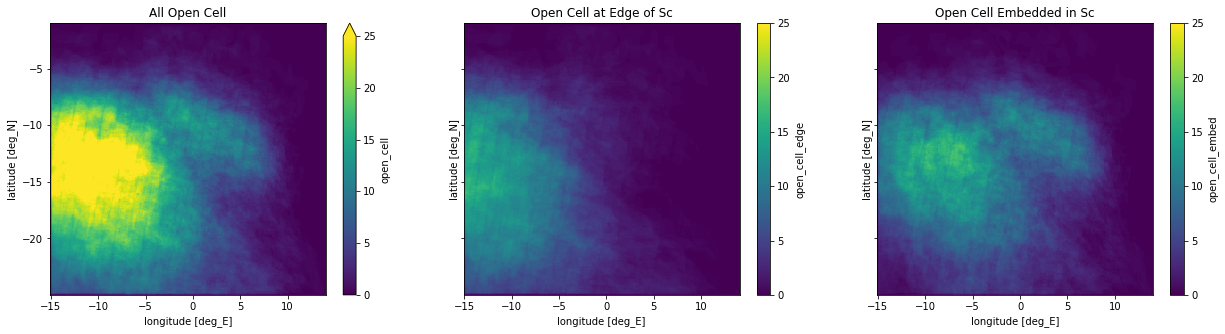

In [5]:
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(21, 5))
(ds.open_cell.mean(dim='time')*100).plot(ax=ax1, vmin=0, vmax=25)
ax1.set_title('All Open Cell')
(ds.open_cell_edge.mean(dim='time')*100).plot(ax=ax2, vmin=0, vmax=25)
ax2.set_title('Open Cell at Edge of Sc')
(ds.open_cell_embed.mean(dim='time')*100).plot(ax=ax3, vmin=0, vmax=25)
ax3.set_title('Open Cell Embedded in Sc')


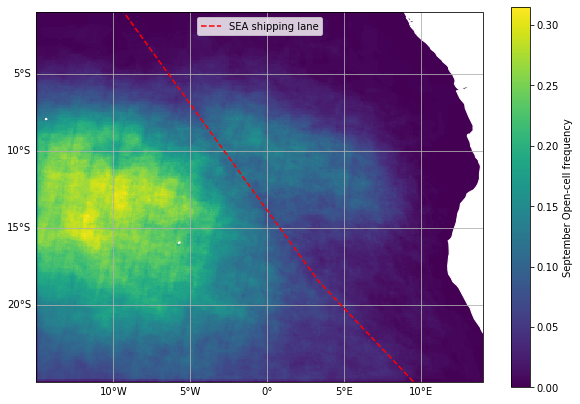

In [10]:
# ga = plt.axes(projection=ccrs.PlateCarree())
fig, ga = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(10,7))
p = ds.open_cell.mean(dim='time').plot(
                                       subplot_kws=dict(facecolor="gray"),
                                       cbar_kwargs=dict(label='September Open-cell frequency'), 
#                                        vmin=0.05, vmax=0.15,
#                                        cmap='jet',
                                       transform=ccrs.PlateCarree()
                                       )
ga.plot([18, -18], [-34, 11], color='red',  ls='--', transform=ccrs.Geodetic(), label='SEA shipping lane')
ga.set_extent([-15, 14, -25, -1], crs=ccrs.PlateCarree())
gl = ga.gridlines(draw_labels=True, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5))
ga.add_feature(cartopy.feature.LAND, facecolor='white', zorder=1)
gl.top_labels = False
gl.right_labels = False
ga.legend(loc='upper center')

# fig.savefig('/home/disk/eos4/jkcm/Data/MEASURES/abel_data/open_mcc_map.png', bbox_inches='tight')
